평가문항	상세기준
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?	
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?	
CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.
3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?	
CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.


결과적으로 CAM보다 Grad-CAM이 더 나은 성능을 보여주는 것으로 확인되었음
 - map에서도 활성화된 부분이 더 많았고 바운딩 박스의 iou가 더 높은 것으로 확인됨

In [5]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

import os
import multiprocessing

tf.config.list_physical_devices('GPU')

# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

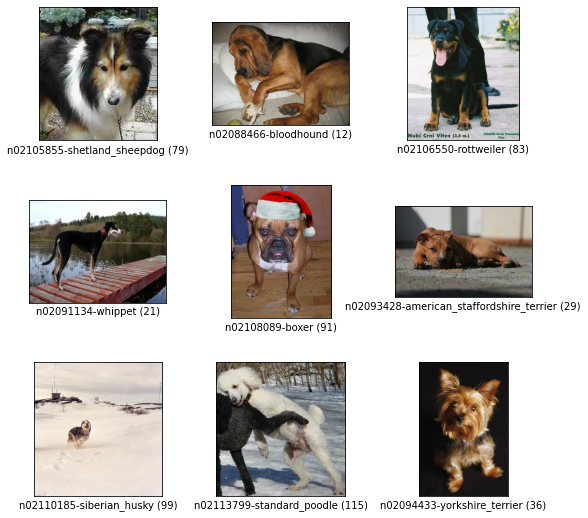

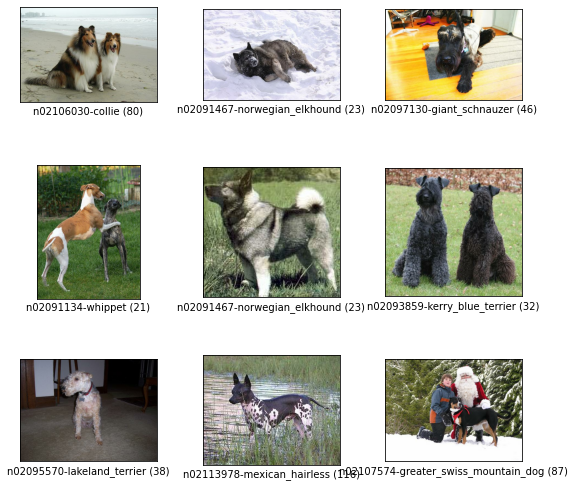

In [3]:
tfds.show_examples(ds_train, ds_info)

tfds.show_examples(ds_test, ds_info)

ds_info.features

num_classes = ds_info.features["label"].num_classes


In [4]:
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes,'softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

cam_model.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [6]:
cpu_count = multiprocessing.cpu_count()
print("사용 가능한 CPU 수:", cpu_count)


사용 가능한 CPU 수: 4


In [7]:

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=4
    )
    ds = ds.batch(batch_size)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)


(16, 224, 224, 3)
(16,)


In [8]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/2
750/750 [==============================] - 158s 201ms/step - loss: 2.2239 - accuracy: 0.4423 - val_loss: 3.4672 - val_accuracy: 0.1877
Epoch 2/2
750/750 [==============================] - 153s 204ms/step - loss: 0.6603 - accuracy: 0.8223 - val_loss: 1.2572 - val_accuracy: 0.6344


In [24]:
cam_model_path = '/data/cam_model.h5'


cam_model.save(cam_model_path)


75


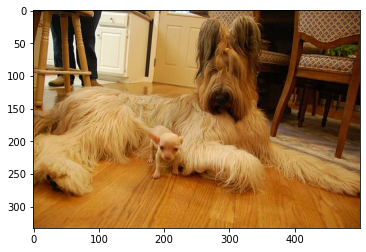

In [64]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()


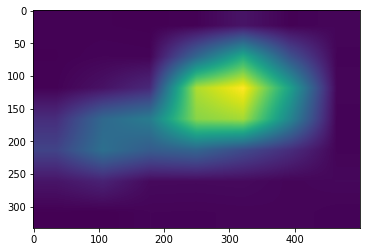

In [65]:
cam_model = tf.keras.models.load_model(cam_model_path)

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1] #가로
    height = item['image'].shape[0] #세로
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    #배치 축 추가로 형태 맞춰서 모델 전달 (layer result,softmax result)
    #마지막 acitvation의 output과 dense output
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) 
    conv_outputs = conv_outputs[0, :, :, :] # 첫번째 결과 선택 > 1,7,7,2048 > 7,7,2048
    
    # 모델의 weight activation은 마지막 layer에 있습니다. 
    # softmax층의 가중치 가져오기 2048,120, 0 = 가중치, 1 = 편향
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) # 7,7
    for i, w in enumerate(class_weights[:, class_idx]): # item 클래스 이미지의 채널 가중치 
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i] # 빈 이미지에 채널별로 레이어에서 나온 값 곱해서 더하기

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

cam_image = generate_cam(cam_model, item) 
plt.imshow(cam_image) # 가중치가 높았던 픽셀의 경우 밝게 표시
plt.show()

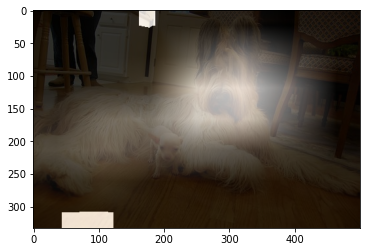

In [66]:
def visualize_cam_on_image(src1, src2, alpha=0.8):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8) #겹치기 위해서 형태 맞추기

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image) #음수의 경우 흰색으로 나옴
plt.imshow(blended_image) 
plt.show()


116


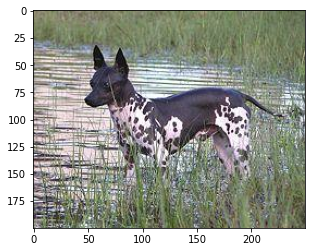

In [67]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다. 첫번째 이미지의 layer output
        # 배치 형태로 리턴하는데 이미지 하나 선택하는 것(하나를 넣었기 때문)
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image) #relu
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

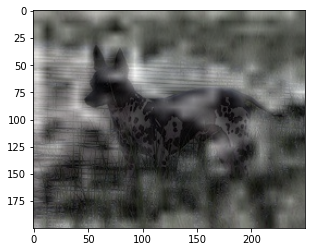

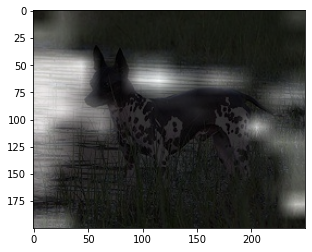

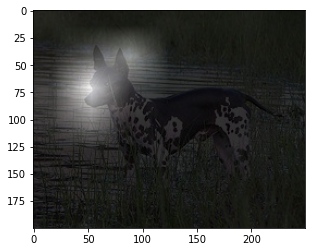

In [69]:

grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()


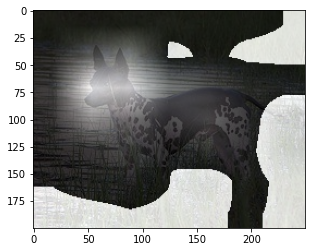

In [70]:
#cam과 비교
cam_image = generate_cam(cam_model, item)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()


80


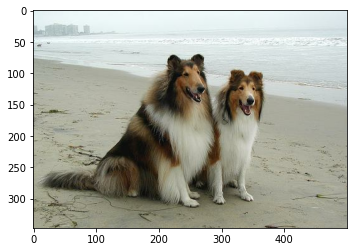

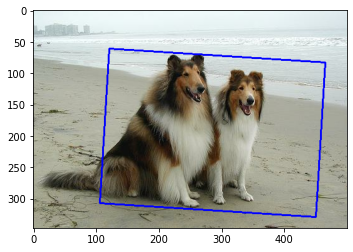

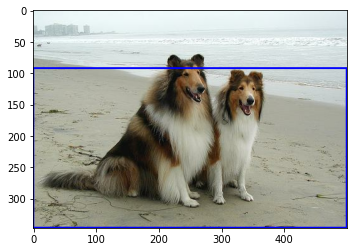

In [82]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh #array에서 해당 조건에 따라 True,False 리턴
    cam_image[low_indicies] = 0 # True인 대상 0으로 변경 
    cam_image = (cam_image*255).astype(np.uint8) #기존 이미지로 복구
    
    #윤곽선 찾는 함수
    #cv2.RETR_TREE: 윤곽선 검출 모드로, 모든 윤곽선을 계층 구조로 반환
    #cv2.CHAIN_APPROX_SIMPLE: 윤곽선을 압축하여 저장하는 방식으로, 윤곽선을 구성하는 좌표 중 중요한 좌표만 저장
    #첫 번째 반환값은 윤곽선(contours) 정보이고, 두 번째 반환값은 계층 정보(hierarchy)
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #일반적으로 contours 리스트에는 여러 개의 윤곽선 정보가 포함될 수 있습니다. 
    #첫 번째 윤곽선은 대부분 가장 외곽에 있는 윤곽선이거나, 계층 구조에서 최상위에 있는 윤계층의 윤곽선
    cnt = contours[0] #[0] 해도 contours랑 같음; 다차원일 경우 각기 다른 윤곽선 정보 갖고있음

    rotated_rect = cv2.minAreaRect(cnt) # 윤곽선을 둘러싸는 최소 회전 사각형
    rect = cv2.boxPoints(rotated_rect) #회전 사각형의 꼭지점 반환
    rect = np.int0(rect) # 꼭지점 좌표를 정수형으로 변환
    return rect

cam_image = generate_cam(cam_model, item)
c_rect = get_bbox(cam_image) #shape (4,2)

bbox_c_image = copy.deepcopy(item['image'])
#이미지에 윤곽선을 그리기 위한 함수
bbox_c_image = cv2.drawContours(bbox_c_image, [c_rect], 0, (0,0,255), 2) #이미지, 윤곽선 정보, 인덱스, 윤곽선 색상, 두께
plt.imshow(bbox_c_image)
plt.show()

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
gc_rect = get_bbox(grad_cam_image) #shape (4,2)

bbox_gc_image = copy.deepcopy(item['image'])
#이미지에 윤곽선을 그리기 위한 함수
bbox_gc_image = cv2.drawContours(bbox_gc_image, [gc_rect], 0, (0,0,255), 2) #이미지, 윤곽선 정보, 인덱스, 윤곽선 색상, 두께
plt.imshow(bbox_gc_image)
plt.show()

In [83]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
# bounding box의 최소값과 최대값을 계산하고, 이를 리스트로 반환하는 함수
# item 정보에 bbox 값이 있기때문에 비교하기위한 함수
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]), #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

def get_iou(boxA, boxB): #겹치는 박스 값 구하기
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]) #박스 사이즈
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]) #박스 사이즈
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

c_pred_bbox = rect_to_minmax(c_rect, item['image'])

gc_pred_bbox = rect_to_minmax(gc_rect, item['image'])


print(f"cam_iou {get_iou(c_pred_bbox, item['objects']['bbox'][0])}")
print(f"grad_cam_iou {get_iou(gc_pred_bbox, item['objects']['bbox'][0])}")



cam_iou 0.37568848621268586
grad_cam_iou 0.4641567208863383
